<a href="https://colab.research.google.com/github/dung18520632/CS114.K21/blob/master/Case_study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"hoangvandung","key":"536b985b25a4e735caa0dff6dcb92a3b"}'}

In [8]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [9]:
!kaggle datasets download -d rmisra/news-headlines-dataset-for-sarcasm-detection/kernels --force

  0% 0.00/3.30M [00:00<?, ?B/s]
100% 3.30M/3.30M [00:00<00:00, 112MB/s]


In [10]:
!unzip news-headlines-dataset-for-sarcasm-detection.zip

Archive:  news-headlines-dataset-for-sarcasm-detection.zip
  inflating: Sarcasm_Headlines_Dataset.json  
  inflating: Sarcasm_Headlines_Dataset_v2.json  


In [11]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from keras.preprocessing import text, sequence
from nltk.tokenize.toktok import ToktokTokenizer
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
from nltk import pos_tag
from nltk.corpus import wordnet
import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout,Bidirectional
import tensorflow as tf

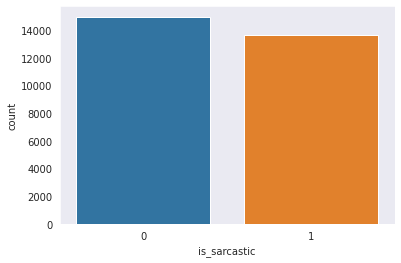

In [12]:
df = pd.read_json("/content/Sarcasm_Headlines_Dataset_v2.json", lines=True)
del df['article_link']
df.head()
sns.set_style("dark")
sns.countplot(df.is_sarcastic)


In [13]:
nltk.download("stopwords")
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [14]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)
# Removing URL's
def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text)
#Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)
#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    return text
#Apply function on review column
df['headline']=df['headline'].apply(denoise_text)

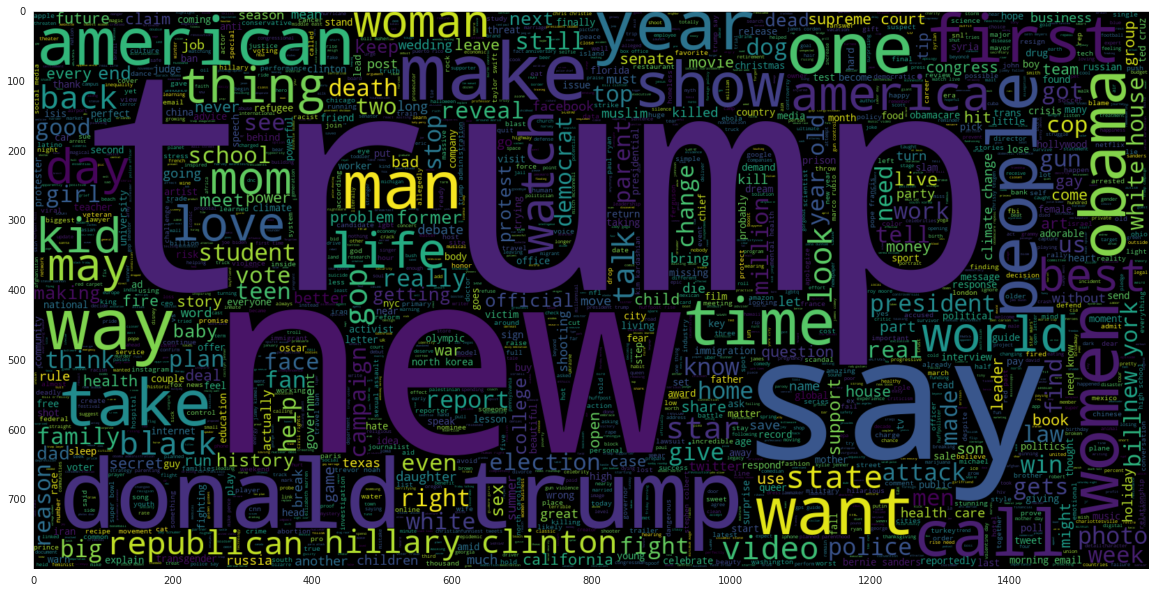

In [15]:
plt.figure(figsize = (20,20)) # Text that is Not Sarcastic
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.is_sarcastic == 0].headline))
plt.imshow(wc , interpolation = 'bilinear')

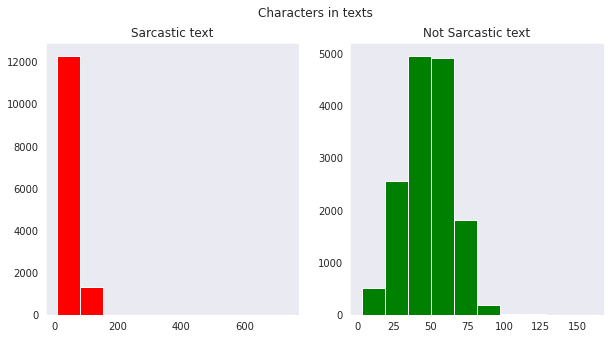

In [16]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
text_len=df[df['is_sarcastic']==1]['headline'].str.len()
ax1.hist(text_len,color='red')
ax1.set_title('Sarcastic text')
text_len=df[df['is_sarcastic']==0]['headline'].str.len()
ax2.hist(text_len,color='green')
ax2.set_title('Not Sarcastic text')
fig.suptitle('Characters in texts')
plt.show()

In [17]:
words = []
for i in df.headline.values:
    l = []
    for j in i.split():
        l.extend(i.split())
        break
    words.append(l)  


In [18]:
import gensim
#Dimension of vectors we are generating
EMBEDDING_DIM = 200

#Creating Word Vectors by Word2Vec Method (takes time...)
w2v_model = gensim.models.Word2Vec(sentences = words , size=EMBEDDING_DIM , window = 5 , min_count = 1)


In [19]:
tokenizer = text.Tokenizer(num_words=35000)
tokenizer.fit_on_texts(words)
tokenized_train = tokenizer.texts_to_sequences(words)
x = sequence.pad_sequences(tokenized_train, maxlen = 20)

In [20]:
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)

38072


In [21]:
# Function to create weight matrix from word2vec gensim model
def get_weight_matrix(model, vocab):
    # total vocabulary size plus 0 for unknown words
    vocab_size = len(vocab) + 1
    # define weight matrix dimensions with all 0
    weight_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
    # step vocab, store vectors using the Tokenizer's integer mapping
    for word, i in vocab.items():
        weight_matrix[i] = model[word]
    return weight_matrix

In [22]:
embedding_vectors = get_weight_matrix(w2v_model, tokenizer.word_index)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


In [23]:
model = Sequential()
#Non-trainable embeddidng layer
model.add(Embedding(vocab_size, output_dim=EMBEDDING_DIM, weights=[embedding_vectors], input_length=20, trainable=True))
#LSTM 
model.add(Bidirectional(LSTM(units=128 , recurrent_dropout = 0.3 , dropout = 0.3)))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=keras.optimizers.Adam(lr = 0.01), loss='binary_crossentropy', metrics=['acc'])

del embedding_vectors

In [25]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 20, 200)           7614400   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               336896    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 7,951,553
Trainable params: 7,951,553
Non-trainable params: 0
_________________________________________________________________


In [26]:
x_train, x_test, y_train, y_test = train_test_split(x, df.is_sarcastic , test_size = 0.3 , random_state = 0) 

In [27]:
history = model.fit(x_train, y_train, batch_size = 128 , validation_data = (x_test,y_test) , epochs = 3)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 20033 samples, validate on 8586 samples
Epoch 1/3
20033/20033 [==============================] - 16s 799us/step - loss: 0.5088 - acc: 0.7412 - val_loss: 0.4134 - val_acc: 0.8105
Epoch 2/3
20033/20033 [==============================] - 14s 689us/step - loss: 0.1651 - acc: 0.9363 - val_loss: 0.5109 - val_acc: 0.8026
Epoch 3/3
20033/20033 [==============================] - 14s 680us/step - loss: 0.0381 - acc: 0.9861 - val_loss: 0.7894 - val_acc: 0.7994


In [47]:
import pandas as pd
test=pd.read_csv("/content/drive/My Drive/Colab Notebooks/dataminer .csv",encoding= 'unicode_escape',names=["headline", "is_sarcastic"])
test["is_sarcastic"]=0
test.head(1000)

,headline,is_sarcastic
0,"After Weeks Of Anticipation, Trump Rally Crowd...",0
1,"Trump Camp Lashes Media, 'Radical Protesters' ...",0
2,Trump Fires U.S. Attorney Who Led Probes Of Th...,0
3,Public Enemy Tells 'Dictator' Trump To ?Shut T...,0
4,Who Owns A River? The Question Is Tearing This...,0
...,...,...
995,Former Minneapolis Mayor: Democrats ?Shouldn?t...,0
996,North Carolina Dog Didn't Have Coronavirus Aft...,0
997,D.C. Man Who Opened Door To Protesters: I Hope...,0
998,Washington Archbishop Condemns Trump's Visit T...,0


In [48]:
test['headline']=test['headline'].apply(denoise_text)

In [32]:
words_test = []
for i in test.headline.values:
    l = []
    for j in i.split():
        l.extend(i.split())
        break
    words_test.append(l) 

In [33]:
print(words_test)

[['Weeks', 'Anticipation,', 'Trump', 'Rally', 'Crowd', 'Underwhelms'], ['Trump', 'Camp', 'Lashes', 'Media,', "'Radical", "Protesters'", 'Lackluster', 'Rally', 'Turnout'], ['Trump', 'Fires', 'U.S.', 'Attorney', 'Led', 'Probes', "President's", 'Men'], ['Public', 'Enemy', 'Tells', "'Dictator'", 'Trump', '?Shut', 'F**k', "Up'", 'Explosive', 'New', 'Song'], ['Owns', 'River?', 'Question', 'Tearing', 'Community', 'Apart'], ['Still', 'Get', 'COVID-19', 'Hit', 'Black', 'People', 'Harder,', 'Read'], ['Twin', 'Trump', "'Bunker", "Baby'", 'Balloons', 'Make', 'Scene', 'Ahead', 'Tulsa', 'Rally'], ['Police', 'Arrest', 'Peaceful', 'Protester', 'Sitting', 'Alone', 'Trump', 'Rally', 'Venue'], ['Trump', 'Uses', 'Racist', 'Terms', "'Kung", "Flu'", "'Chinese", "Virus'", 'Describe', 'COVID-19'], ['Joe', 'Biden', 'Raised', 'Money', 'Donald', 'Trump', 'First', 'Time'], ['Florida', 'Governor', 'Ripped', 'Trying', 'Pin', 'COVID-19', 'Spike', 'Hispanic', 'Workers'], ['Judge', 'Rejects', 'White', 'House', 'Reques

In [34]:
w2v_model_test = gensim.models.Word2Vec(sentences = words_test , size=EMBEDDING_DIM , window = 5 , min_count = 1)

In [43]:
test_1 = []
for i in words_test:
  l = []
  for j in i:
    if j not in list(tokenizer.word_index):
      continue
    else:
      l.append(tokenizer.word_index[j])
  test_1.append(l)

In [44]:
tokenizer = text.Tokenizer(num_words=35000)
tokenizer.fit_on_texts(words_test)
tokenized_train = tokenizer.texts_to_sequences(words_test)
test_head= sequence.pad_sequences(test_1, maxlen = 20)

In [45]:
pred = model.predict(test_head)

In [46]:
pred_final = np.where(pred > 0.5, 1, 0)
print(pred_final)

[[0]
 [0]
 [0]
 ...
 [0]
 [0]
 [0]]


In [49]:
from sklearn.metrics import accuracy_score

print(accuracy_score(test['is_sarcastic'].values, pred_final))

0.9840796019900497
